In [273]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [274]:
#sqqq and tqqq are taken as IBdata feed not for SPXS 
path = '/home/octo/Dropbox/IQ_data/'
spy=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
sqqq= pd.read_csv(path + 'SQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
tqqq=pd.read_csv(path + 'TQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spy=spy.tail(140000)
sqqq=sqqq.tail(140000)
tqqq=tqqq.tail(140000)

In [335]:
#df for datascience
df=pd.DataFrame(data=spy.open)

In [336]:
#df['time']=df.index.strftime('%H:%M:%S')
time=df.index.strftime('%H:%M:%S')

# Feature Generation

In [337]:
# reversal, when market up or down
NL=pd.rolling_sum(pd.DataFrame(data=spy.open-spy.close.shift(60)),12)
NLqtop=pd.rolling_quantile(NL,720,.8)
NLqbot=pd.rolling_quantile(NL,720,.2)
df['R']=np.where(NL>NLqtop,1,np.where(NL<NLqbot,-1,0)) # only considering 1 and 0

In [298]:
df['speed']=pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(1))),60)
speedQtop=pd.rolling_quantile(df.speed,1000,.7)
speedb=np.where(df.speed<speedQtop,1,0) # 1 shows acceptable speed == speed below 70%

In [299]:
# only when volume ==1
voltop=pd.rolling_quantile(spy.volume,1000,.7)
df['vol']=np.where(spy.volume>voltop,1,0)

#### ^^^ only dataset for speed ==1 and vol==1 ans R==1

In [300]:
P=(spy.high+spy.low+spy.close)/3
vwap=pd.rolling_sum(spy.volume*P,12)/pd.rolling_sum(spy.volume,12)
df['spread']=pd.rolling_sum(pd.DataFrame(data=(spy.open-vwap)),60)

In [301]:
# difference at '09:30:05' from last day close
EO=np.where(time=='09:30:05',df.open-spy.close.shift(1),0)
df['EO']=np.where(time=='09:30:05',df.open-spy.close.shift(1),0)     
df['EO']=df.EO.replace(to_replace=0, method='ffill')

In [302]:
H=pd.rolling_max(spy.high,4600)
L=pd.rolling_min(spy.low,4600)
M=(H+L)/2

In [303]:
df['OF']=np.where(time=='09:30:05',df.open,0)
df['OF']=df.OF.replace(to_replace=0, method='ffill')
df['HF']=np.where(time=='09:30:05',H,0)
df['HF']=df.HF.replace(to_replace=0, method='ffill')
df['LF']=np.where(time=='09:30:05',L,0)
df['LF']=df.LF.replace(to_replace=0, method='ffill')
df['MF']=np.where(time=='09:30:05',M,0)
df['MF']=df.MF.replace(to_replace=0, method='ffill')

# for finding market state. EO for sentiment 
#df['HO']=df.OF-df.HF # +ve shows jump up
#df['LO']=df.LF-df.OF # +ve shows jump down
#df['MO']=df.OF-df.MF # +ve for state 3 or buy | -ve for state 2 or SS
HO=df.OF-df.HF # +ve shows jump up
LO=df.LF-df.OF # +ve shows jump down
MO=df.OF-df.MF # +ve for state 3 or buy | -ve for state 2 or SS
# for finding market state. EO for sentiment 
#df['HM']=df.HF-df.MF # +ve shows jump up
#df['LM']=df.MF-df.LF # +ve shows jump down

In [304]:
#Market spread from opening price
#df['EO']=np.where(EO==0,EO[time=='09:30:05'][-1],0)
#df['OO']=df.open-O # changing points

In [305]:
#H L M price spread from opening price

#df['HO']=df.open-df.HF # positive spread if at state 4
#df['LO']=df.LF-df.open # +ve shows jump down
#df['HO']=df.open-H # positive spread if at state 4
#df['LO']=L- df.open # +ve shows jump down
#df['MD']=df.open-df.MF # +ve for state 3 or buy | -ve for state 3 or SS
df['OD']=df.open-df.OF

In [306]:
#SEntiment

df['S']=np.where(df.EO>0,1,np.where(df.EO<-0,-1,0))

In [307]:
#market state

df['MS']=np.where(HO>0,4,np.where(MO>0,3,np.where(MO<0,2,np.where(LO>0,1,0))))

# Signal

In [308]:
UT=pd.rolling_max(P,60)+pd.rolling_mean((spy.high-spy.low), window=60)-0.02
DT=pd.rolling_min(P,60)-pd.rolling_mean((spy.high-spy.low), window=60)+0.02
df['BS']=np.where(df.open<=DT,1,np.where(df.open>=UT,-1,0))

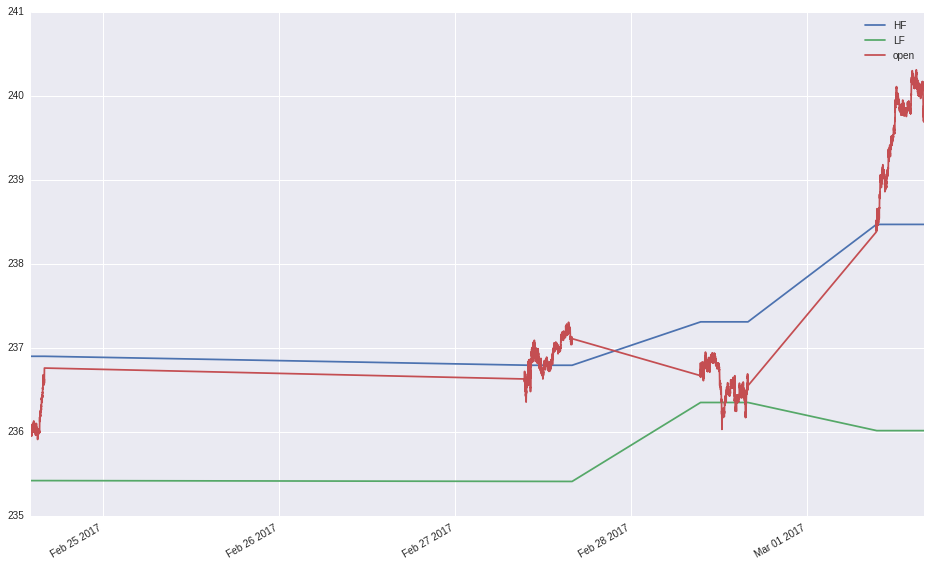

In [310]:
# market jumped up and down

df[['HF','LF','open']].tail(15000).plot(figsize=(16, 10))
plt.show()

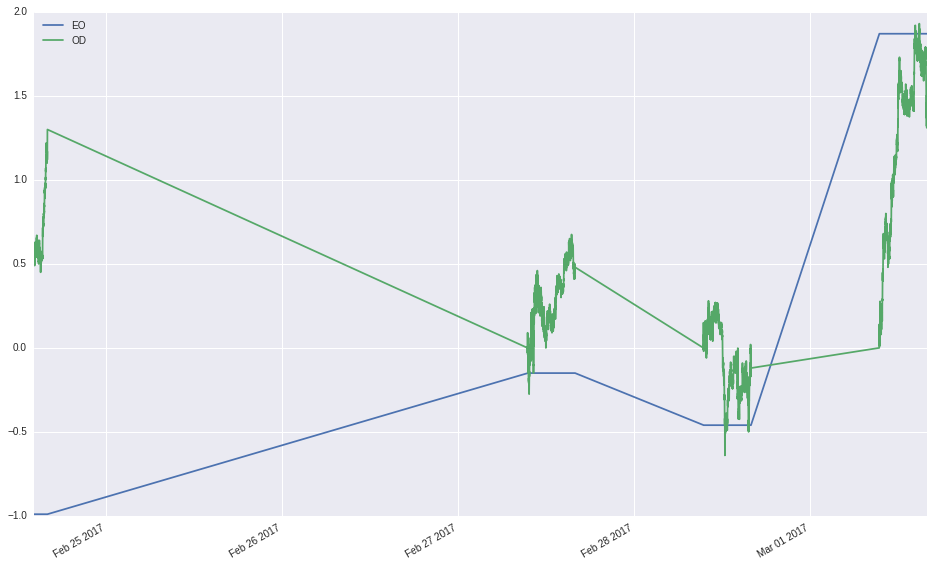

In [311]:
df[['EO','OD']].tail(15000).plot(figsize=(16, 10))
plt.show()

### Regression for feature generation: Reversal

In [313]:
p60=pd.DataFrame(data=spy.close.shift(60))
df=df.tail(130000)

In [320]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(pd.DataFrame(spy.open.tail(130000)),pd.DataFrame(p60.tail(130000)))
df['pr']=regr.predict(pd.DataFrame(p60.tail(130000)))

In [321]:
err=df.open-df.pr
errQtop=pd.rolling_quantile(err,1000,.95)
errQbot=pd.rolling_quantile(err,1000,.05)
df['err']=np.where(err>errQtop,1,np.where(err<errQbot,-1,0))

In [323]:
df=df.dropna()

In [327]:
df_ml=df

In [326]:
"""df_ml['speed']=df.speed
df_ml['V']=df.vol
df_ml['R']=df.R
df_ml['spread']=df.spread
df_ml['EO']=df.EO
df_ml['OD']=df.OD
df_ml['HF']=df.HF
df_ml['LF']=df.LF
df_ml['S']=df.S
df_ml['MS']=df.MS
df_ml['err']=df.err"""

"df_ml['speed']=df.speed\ndf_ml['V']=df.vol\ndf_ml['R']=df.R\ndf_ml['spread']=df.spread\ndf_ml['EO']=df.EO\ndf_ml['OD']=df.OD\ndf_ml['HF']=df.HF\ndf_ml['LF']=df.LF\ndf_ml['S']=df.S\ndf_ml['MS']=df.MS\ndf_ml['err']=df.err"

In [334]:
df_ml.tail()

,open,R,speed,vol,spread,EO,OF,HF,LF,MF,OD,S,MS,BS,pr,err
2017-03-01 15:58:00,239.77,1,0.0164,1,-1.190232,1.87,238.38,238.47,236.015,237.2425,1.39,1,3,0,240.019313,-1
2017-03-01 15:58:05,239.75,1,0.0114,1,-1.185143,1.87,238.38,238.47,236.015,237.2425,1.37,1,3,0,240.004330,-1
2017-03-01 15:58:10,239.75,1,0.0014,1,-1.176132,1.87,238.38,238.47,236.015,237.2425,1.37,1,3,0,240.004430,-1
2017-03-01 15:58:15,239.77,1,0.0015,1,-1.156785,1.87,238.38,238.47,236.015,237.2425,1.39,1,3,0,240.014319,-1
2017-03-01 15:59:20,239.69,1,-0.0282,1,-0.482317,1.87,238.38,238.47,236.015,237.2425,1.31,1,3,1,239.894451,-1


In [333]:
# reduce dataset based on volume and speed
df_ml=df_ml[df_ml.err!=0] # all decision when volume above 30% or vol==1
df_ml=df_ml[speedb!=0] # 1 shows acceptable speed
df_ml=df_val.dropna()

ValueError: Item wrong length 140000 instead of 14458.

In [332]:
len(df.speed)

130000

In [331]:
len(df_ml.speed)

14458

# Machine Learning